# Bayesian Fisher test, based on Bob carpenter lecture, and
# https://www.tjmahr.com/bayesian-fisher-exact-test/
# Count data analysis by Kruschke (2014), chapter 14, only implemeted in JAGS, only resource i could find for similar analysis to chi-square. 

In [6]:
# Import all relevant librairies for analysising data with pystan

import matplotlib.pyplot as plt
%matplotlib inline
import os
import numpy as np 
import pandas as pd
import pystan as ps
import arviz as az

#Set working dircetory to wherever data is saved on local machine.

os.chdir(r"\Users\harri\OneDrive\Documents\Stats 2")

# The Data is a simple 2x2 contingency table of counts for males and females with and their handedness 

In [38]:
# Example data set generated in R and saved for upload into jupyter.
# Data 
df = pd.read_csv("Handedness")
df.head()


,left,right
0,9,43
1,4,44


$$left handed \sim Binomial(Total group, \theta)[likelihood]$$ 
$$Beta \sim (a,b)[prior]$$

In [27]:
# Compile stan code

Baye_FisherT = """
data {
  int<lower=0> beta_a; // Specifying the a parameter value for beta prior.
  int<lower=0> beta_b; // Specifying the b parameter value for beta prior.
  int<lower=0> n_total_1; // Total male numbers for both right/left handedness.
  int<lower=0> n_total_2; //Total female numbers for both right/left handedness.
  int<lower=0> n_hits_1; // Number of left handed males.
  int<lower=0> n_hits_2; // Number of right handed females.
}
parameters { 
//probability of left handedness. The probabiltiy are bounded between by 0 and 1 as required of beta distribution.

  real<lower=0, upper=1> theta_1; //parameter estimate for males.
  real<lower=0, upper=1> theta_2; //parameter estimate for females.
}
model {
// prior specified as a beta distribution with alpha set as 5 and beta 40

  theta_1 ~ beta(beta_a, beta_b);
  theta_2 ~ beta(beta_a, beta_b);
  
  //likelihood (link to data) for this model specifies the data
  
    n_hits_1 ~ binomial(n_total_1, theta_1);
    n_hits_2 ~ binomial(n_total_2, theta_2);
  
}
generated quantities {
  // generating diff values between the thet  
  
  real diff; // genrate diff value as a real number
  diff = theta_1 - theta_2; // assign diff value as the parameter
}
"""

In [33]:
#Values hardcodied below

FisherT_data = {
    "beta_a": 5,
    "beta_b": 40,
    "n_total_1": 9 + 43,
    "n_total_2": 4 + 44,
    "n_hits_1": 9,
    "n_hits_2": 4}

# Fit Bayesian Fisher test using Stan

Fisher_Fit = ps.stan(model_code = Baye_FisherT, data = FisherT_data, iter=2000, chains=4,seed=340)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_10bdfc6362f3af35b390918305ad4fe7 NOW.


In [30]:
print(Fisher_Fit)

Inference for Stan model: anon_model_10bdfc6362f3af35b390918305ad4fe7.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

          mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
theta_1   0.14  5.7e-4   0.04   0.08   0.12   0.14   0.17   0.22   3888    1.0
theta_2    0.1  4.8e-4   0.03   0.05   0.08   0.09   0.12   0.16   3965    1.0
diff      0.05  7.3e-4   0.05  -0.04   0.02   0.05   0.08   0.14   3998    1.0
lp__    -70.61    0.02   0.97  -73.2  -71.0 -70.32  -69.9 -69.64   1767    1.0

Samples were drawn using NUTS at Thu Nov  5 07:50:05 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


## The model uses an informed prior (Beta(5,40), skepticla of a difference) and shows that the diff between left handedness males and females has a posterior mean of .05% but with a 95% credibilty interval [-.04, .14]. If you have to make descision in the vain of confidence intervals in a frequentist analysis the values of handedness cross zero, therfore there is little evidence suggest a difference in left handedness between males and females.

# Plotting Posteriors

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001E0F4AA1688>,
      dtype=object)

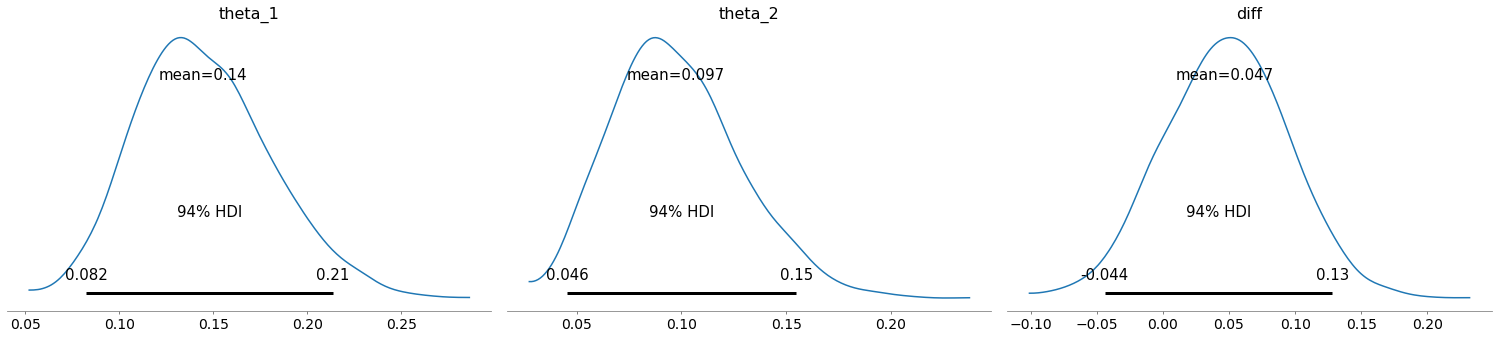

In [31]:
az.plot_posterior(Fisher_Fit)

# Trace plots for MCMC sampler

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001E0F628C608>,
      dtype=object)

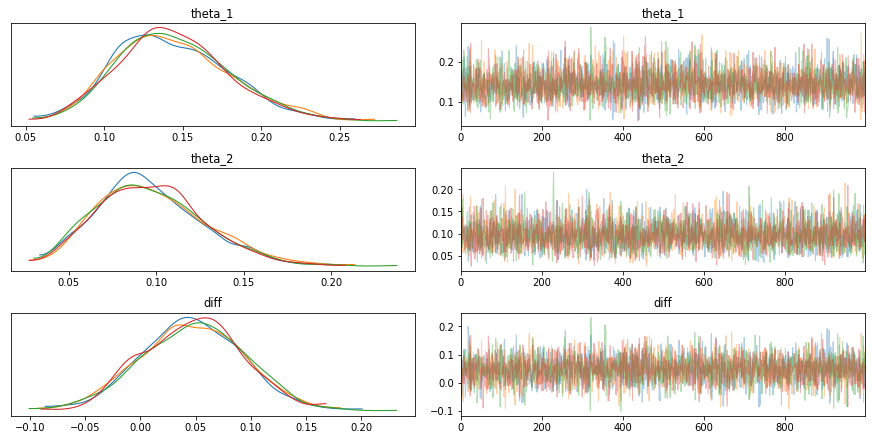

In [32]:
az.plot_trace(Fisher_Fit)